In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from math import *
import random
from copy import deepcopy
import numpy as np


In [8]:

def argmin(values):
    return min(enumerate(values), key=lambda x: x[1])[0]
def avg(values):
    return float(sum(values))/len(values)

In [9]:
def readfile(filename):
    data = []
    with open(filename, 'r') as f:
        data = f.readlines()
    data = [tuple(map(float, line.split(','))) for line in data]
    return data

In [10]:
def distance_euclidean(p1, p2):
    distance = None
    dist = [(x1-x2)**2 for x1, x2 in zip(p1, p2)]
    distance = sqrt(sum(dist))
    return distance

def distance_manhattan(p1, p2):
    distance = None
    distance = sum([abs(x1-x2) for x1, x2 in zip(p1, p2)])
    return distance


In [11]:
def initialization_kmeansplusplus(data, distance, k):

    means = []
    # The first centroid is randomly selected
    means.append(random.sample(data, 1)[0])
    # Current minimum distance squared from any centroid
    # The probability with which to select a point will be proportional to this
    min_dist = [float('Inf')] * len(data)
    
    # Going over means; adding 1 new mean in each loop
    for i in range(k-1):
        # Updating minimum for all points
        for j in range(len(data)):
            # Calculate minimum distance
            d = distance(means[i], data[j])
            # Squaring the distance since the probability will be proportional to this.
            d = d*d
            if d < min_dist[j]:
                min_dist[j] = d  
        
        # Normalising min_dist array to get an array of probabilities
        s = sum(min_dist)
        prob = [i/s for i in min_dist]
        # Choose a random index with probabilities proportional to min_dist
        idx = np.random.choice(len(data), 1, p=prob)[0]
        # Append the chosen point to means
        means.append(data[idx])
    assert len(means) == k
    return means


In [12]:
def iteration_one(data, means, distance):
    new_means = []
    k = len(means)
    dimension = len(data[0])
    new_means = [tuple(0 for i in range(dimension))] * k
    counts = [0.0] * k
    for point in data:
        closest = 0
        min_dist = float('Inf')
        for i in range(k):
            d = distance(point, means[i]) 
            if d < min_dist:
                min_dist = d
                closest = i
        new_means[closest] = tuple([sum(x) for x in zip(new_means[closest], point)])
        counts[closest] += 1

    for i in range(k):
        # import pdb; pdb.set_trace()
        if counts[i] == 0:
            new_means[i] = means[i]
        else:
            new_means[i] = tuple(t/counts[i] for t in new_means[i])
    return new_means

def hasconverged(old_means, new_means, epsilon=1e-1):
    converged = False

    for i in range(len(old_means)):
        p = [abs(x1-x2) > epsilon for x1, x2 in zip(old_means[i], new_means[i])]
        if True in p:
            return False
    converged = True
    return converged


In [13]:
def iteration_many(data, means, distance, maxiter, epsilon=1e-1):
    all_means = []
    all_means.append(means)

    means_copy = deepcopy(means)
    for i in range(maxiter):
        new_means = iteration_one(data, means_copy, distance)
        all_means.append(new_means)
        if hasconverged(means_copy, new_means, epsilon):
            break
        means_copy = new_means

    return all_means


In [14]:
def performance_SSE(data, means, distance):
    sse = 0

    for point in data:
        min_dist = float('Inf')
        for i in range(len(means)):
            d = distance(point, means[i])
            if d < min_dist:
                min_dist = d
        sse += min_dist*min_dist
    return sse


In [15]:
import sys
import argparse
import matplotlib.pyplot as plt
from itertools import cycle
from pprint import pprint as pprint


def visualize_data(data, all_means, args):
    print('Visualizing...')
    means = all_means[-1]
    k = args['k']
    distance = args['dist']
    clusters = [[] for _ in range(k)]
    for point in data:
        dlist = [distance(point, center) for center in means]
        clusters[argmin(dlist)].append(point)

    # plot each point of each cluster
    colors = cycle('rgbwkcmy')

    for c, points in zip(colors, clusters):
        x = [p[0] for p in points]
        y = [p[1] for p in points]
        plt.scatter(x,y, c = c)

    # plot each cluster centroid
    colors = cycle('krrkgkgr')
    colors = cycle('rgbkkcmy')

    for c, clusterindex in zip(colors, range(k)):
        x = [iteration[clusterindex][0] for iteration in all_means]
        y = [iteration[clusterindex][1] for iteration in all_means]
        plt.plot(x,y, '-x', c = c, linewidth='1', mew=15, ms=2)
    plt.axis('equal')
    plt.show()

def visualize_performance(data, all_means, distance):

    errors = [performance_SSE(data, means, distance) for means in all_means]
    plt.plot(range(len(all_means)), errors)
    plt.title('Performance plot')
    plt.xlabel('Iteration')
    plt.ylabel('Sum Squared Error')
    plt.show()


if __name__ == '__main__':
    args={}
    args['input'] = '/content/drive/MyDrive/1000.csv'
    args['epsilon'] = 1e-2
    args['k'] = 5
    args['maxiter'] = 10000
    
    args['init'] = initialization_kmeansplusplus
    
    #args['dist'] = distance_manhattan
    args['dist'] = distance_euclidean
    
    args['numexperiments'] = 25

    # Read data
    data = readfile(args['input'])
    print('Number of points in input data: {}\n'.format(len(data)))
    verbose = False

    totalSSE = 0
    totaliter = 0

    for experiment in range(args['numexperiments']):
        print('Experiment: {}'.format(experiment+1))
        random.seed(0 + experiment)
        print('Seed: {}'.format(0 + experiment))

        # Initialize means
        means = initialization_kmeansplusplus(data, args['dist'], args['k'])

        if verbose:
            print('Means initialized to:')
            print(means)
            print('')

        # Run k-means clustering
        all_means = iteration_many(data, means, args['dist'], args['maxiter'], args['epsilon'])

        SSE = performance_SSE(data, all_means[-1], args['dist'])
        totalSSE += SSE
        totaliter += len(all_means)-1
        print('Sum Squared Error: {}'.format(SSE))
        print('Number of iterations till termination: {}'.format(len(all_means)-1))
        print('Convergence achieved: {}'.format(hasconverged(all_means[-1], all_means[-2])))


        if verbose:
            print('\nFinal means:')
            print(all_means[-1]) 
            print('')
            
    print('\n\nAverage SSE: {}'.format(float(totalSSE)/args['numexperiments']))
    print('Average number of iterations: {}'.format(float(totaliter)/args['numexperiments']))

    if args['numexperiments'] == 1:
        # If the data is 2-d and small, visualize it.
        if len(data) < 5000 and len(data[0]) == 2:
            visualize_data(data, all_means, args)

        visualize_performance(data, all_means, args['dist'])


Number of points in input data: 1000

Experiment: 1
Seed: 0
Sum Squared Error: 19662827.96077675
Number of iterations till termination: 3
Convergence achieved: True
Experiment: 2
Seed: 1
Sum Squared Error: 19480067.46824965
Number of iterations till termination: 3
Convergence achieved: True
Experiment: 3
Seed: 2
Sum Squared Error: 19314858.4227151
Number of iterations till termination: 2
Convergence achieved: True
Experiment: 4
Seed: 3
Sum Squared Error: 18769929.8359221
Number of iterations till termination: 2
Convergence achieved: True
Experiment: 5
Seed: 4
Sum Squared Error: 19695954.78169606
Number of iterations till termination: 3
Convergence achieved: True
Experiment: 6
Seed: 5
Sum Squared Error: 19077099.796293955
Number of iterations till termination: 3
Convergence achieved: True
Experiment: 7
Seed: 6
Sum Squared Error: 19752902.962734204
Number of iterations till termination: 3
Convergence achieved: True
Experiment: 8
Seed: 7
Sum Squared Error: 19469294.968686797
Number of ite

Task 2
========


Dataset     |  Average SSE      | Average Iterations
---
   100.csv  |  8472.63311469    |     2.03
---
  1000.csv  |  19324991.4686    |     3.08
---  
  10000.csv |  20785276.2072    |     5.3
---

No the SSE never increases in the k-means algorithm. In fact it can be proven that it will never increase. The decrease happens at two points, one is when we change the label of the points according to the centroid closest to it. This means that the closest centroid distance for every point that get relabelled has decreased, hence overall SSE has to decrease. Now the second step is that we get new means by making them the centroid of the current clusters. We know that the sum of squared distance is minimum from the mean (centroid), so again the SSE will decrease. And this process repeats.

The answer the same for both Euclidean and Manhattan distances

Euclidean 
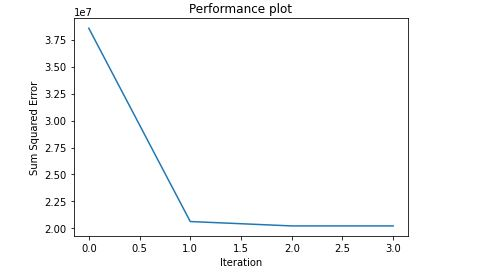



Manhattan
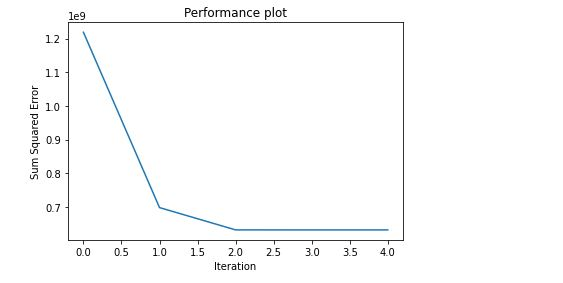

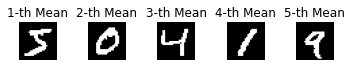

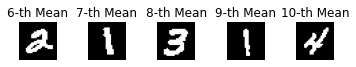

In [16]:

import numpy as np
from matplotlib import pyplot as plt
with open('/content/drive/MyDrive/mnist.csv', 'r') as f:
    fig = plt.figure()
    for index in range(10):
        plt.subplot(5,5, index+1)
        mean = [255*i//1 for i in list(map(float, f.readline().split(',')))]
        pixels = np.array(mean, dtype='uint8')
        pixels = pixels.reshape((28, 28))
        plt.axis('off')
        plt.title('{}-th Mean'.format(index+1))
        plt.imshow(pixels, cmap='gray')
        if index == 4:
          plt.show()
    plt.show()